In [21]:
#https://account.polar.com/ <-Go here to get polar data
import json
import datetime
from datetime import timedelta
import os, zipfile
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

In [37]:
#change width of current notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
data_zip_med=r"D:\OneDrive\Documents\professional\20210710lifeBuddy\misc_not_for_git\polar_flow_test2.zip"
polar_zip=zipfile.ZipFile(data_zip_med)

In [3]:
#read all files in zip to dictionary of file names and json (each value is a training_session)
polar_data_dict={}
for i in polar_zip.filelist:
    polar_data_dict[i.filename]=json.loads(polar_zip.read(i.filename))

In [4]:
polar_df_dict={}
for i,j in polar_data_dict.items():
    if 'training-session-' in i:
        var_datetime_utc=j['timeZoneOffset']
        var_datetime_utc_list=[datetime.datetime.strptime(
            k['dateTime']  ,'%Y-%m-%dT%H:%M:%S.%f') + timedelta(
                minutes=var_datetime_utc) for k in j['exercises'][0]['samples']['heartRate']]
        var_values_list=[k['value'] for k in j['exercises'][0]['samples']['heartRate']]
        df=pd.DataFrame(list(zip(var_datetime_utc_list,var_values_list)), columns=[
            'var_datetime_utc','var_value'])
        df['var_activity']=j['name']
        df['var_periodicity']='seconds'
        df['var_type']='heart rate'
        df['var_unit']='heart rate per second'
        df['user_id']=1
        df['source_filename']=i
        df['time_stamp_utc']=datetime.datetime.utcnow()
        df['var_timezone_utc_delta_in_mins']=var_datetime_utc
        polar_df_dict[i]=df

In [10]:
polar_df_dict[list(polar_df_dict.keys())[0]].head()

,var_datetime_utc,var_value,var_activity,var_periodicity,var_type,var_unit,user_id,source_filename,time_stamp_utc,var_timezone_utc_delta_in_mins
0,2021-03-10 09:28:08.743,56,Other indoor,seconds,heart rate,heart rate per second,1,training-session-2021-03-10-5773099879-a35410f...,2021-08-07 10:11:29.516557,-300
1,2021-03-10 09:28:09.743,55,Other indoor,seconds,heart rate,heart rate per second,1,training-session-2021-03-10-5773099879-a35410f...,2021-08-07 10:11:29.516557,-300
2,2021-03-10 09:28:10.743,56,Other indoor,seconds,heart rate,heart rate per second,1,training-session-2021-03-10-5773099879-a35410f...,2021-08-07 10:11:29.516557,-300
3,2021-03-10 09:28:11.743,56,Other indoor,seconds,heart rate,heart rate per second,1,training-session-2021-03-10-5773099879-a35410f...,2021-08-07 10:11:29.516557,-300
4,2021-03-10 09:28:12.743,57,Other indoor,seconds,heart rate,heart rate per second,1,training-session-2021-03-10-5773099879-a35410f...,2021-08-07 10:11:29.516557,-300


In [18]:
var_datetime_utc_list=polar_df_dict[list(polar_df_dict.keys())[0]].var_datetime_utc.to_list()
obs_x=[(i-var_datetime_utc_list[0]).total_seconds() for i in var_datetime_utc_list]
obs_y=polar_df_dict[list(polar_df_dict.keys())[0]].var_value.to_list()

In [13]:
def michaelis_m_eq(time_var, max_var, shape_var):
    return (max_var *time_var)/(shape_var + time_var)

In [19]:
popt, pcov = curve_fit(michaelis_m_eq, obs_x, obs_y,bounds=(0,np.inf))

In [20]:
popt

array([68.67309524,  1.47589281])

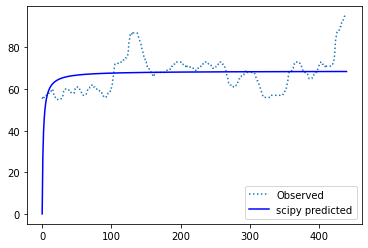

In [36]:
plt.plot(obs_x, obs_y,':', label='Observed')
plt.plot(obs_x,predicted_list,'b-', label='scipy predicted')
# plt.plot(observed_x, predicted_y_excel,'g', label='excel predicted')
plt.legend(loc='best')
plt.show()

In [32]:
predicted_list=[]
for i in obs_x:
    predicted_list.append(michaelis_m_eq(i,popt[0],popt[1]))

In [33]:
predicted_list

[0.0,
 27.73669967082467,
 39.51393154420547,
 46.02864602596988,
 50.16394414228844,
 53.02210619761177,
 55.11563394674365,
 56.71516589001106,
 57.9770975721476,
 58.998108178586406,
 59.84117871125611,
 60.5490973080086,
 61.151951460152894,
 61.67151483913008,
 62.12393335151862,
 62.52143301760825,
 62.87344148385481,
 63.187345326969094,
 63.46901405293584,
 63.72317054990203,
 63.953658042814716,
 64.1636357838009,
 64.35572472773892,
 64.53211749704155,
 64.69466244788855,
 64.84492868526408,
 64.98425688044941,
 65.11379938103873,
 65.23455215631375,
 65.34738045331119,
 65.45303956227734,
 65.55219174565474,
 65.6454201328278,
 65.73324019670135,
 65.81610928925768,
 65.89443460858867,
 65.96857989038291,
 66.0388710559302,
 66.10560100167743,
 66.16903367879794,
 66.22940758260097,
 66.28693874903882,
 66.34182333767357,
 66.39423986618995,
 66.4443511500908,
 66.49230599197955,
 66.53824065735124,
 66.58228016772071,
 66.62453943693151,
 66.66512427239346,
 66.704132259616

In [39]:
pred_y_2=[michaelis_m_eq(i,popt[0],popt[1]) for i in obs_x]

In [41]:
for y_2,y_1 in zip(pred_y_2,predicted_list):
    if y_2=y_1:
        print(y_2,y_1)